Hi. In this notebook, we are going to be training a generative adversarial network (GAN) on the MNIST dataset. Let's go!

### Basic imports

In [ ]:
## Standard libraries
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Progress bar
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


We define a function to set a seed on all libraries we might interact with in this notebook (`numpy` and `torch`). This allows us to make our training reproducible.

In [ ]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


### Step 0: Define inputs

In [ ]:
DATASET_PATH = "/data"  # Path where datasets are downloaded
OUTPUT_PATH = "/figures"  # Path where figures are stored
os.makedirs(OUTPUT_PATH, exist_ok=True)

batch_size = 128  # Batch size during training
image_size = 32  # Spatial size of training images

num_channels = 1  # Number of channels in the images
num_classes = 10  # Number of classes in the dataset
z_size = 100  # Size of generator input (z)

### Step 1: Downloading MNIST

In [ ]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Load the 'training' dataset to use for our task
dataset = MNIST(root=DATASET_PATH, train=True,
                transform=transform, download=True)

# Define the DataLoader
data_loader = data.DataLoader(dataset, batch_size=batch_size,
                              shuffle=True, drop_last=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 111768673.70it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44001341.75it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26283173.32it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22571716.55it/s]


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



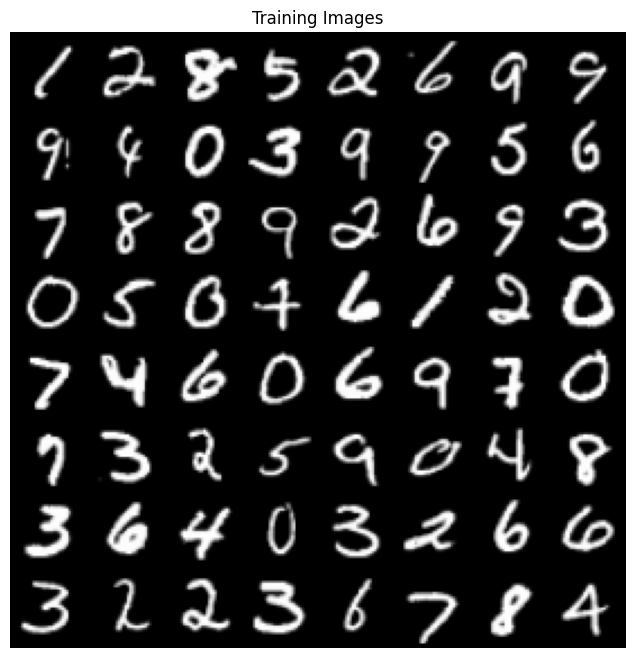

In [ ]:
# Visualizing the images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(make_grid(real_batch[0].to(device)[:64],
                           padding=2, normalize=True).cpu(),
    (1, 2, 0))
  )

### Step 2: Implementation

#### Weight initialization

The authors of the DCGAN paper specify that all model weights shall be randomly initialized from $\mathcal{N}(0, 0.02)$. <br>The `init_weights` function reinitializes all convolutional, conv-transpose, and batch norm layers to meet this criteria.

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

#### Defining the generator

In [ ]:
class Unflatten(nn.Module):
    def __init__(self, C, H, W):
        super().__init__()

        self.C = C
        self.H = H
        self.W = W

    def forward(self, x):
        return x.view(-1, self.C, self.H, self.W)


class Generator(nn.Module):
  def __init__(self, z_dim, image_size, num_channels, num_additional_features=0):
    super().__init__()

    # Determine how many deconv layers to add
    num_deconvolutions, encoded_size, encoded_num_channels = 0, image_size, 16
    while encoded_size > 4 and encoded_size % 2 == 0:
      encoded_size //= 2
      num_deconvolutions += 1
      encoded_num_channels *= 2
    assert num_deconvolutions > 2

    self.z_dim = z_dim
    self._num_additional_features = num_additional_features

    # Define two FC layers
    self.affine_1 = nn.Sequential(
        nn.Linear(z_dim + num_additional_features, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.affine_2 = nn.Sequential(
        nn.Linear(1024, encoded_num_channels * encoded_size * encoded_size),
        nn.BatchNorm1d(encoded_num_channels * encoded_size * encoded_size),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.unflatten = Unflatten(C=encoded_num_channels, H=encoded_size, W=encoded_size)

    # Define deconv layers
    deconvolutions, in_channels = [], encoded_num_channels
    for _ in range(num_deconvolutions - 1):
        out_channels = in_channels // 2
        deconvolution = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        deconvolutions.append(deconvolution)
        in_channels = out_channels
    deconvolutions.append(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=num_channels,
                           kernel_size=4, stride=2, padding=1, bias=False)
    )
    self.deconvolutions = nn.Sequential(*deconvolutions)

  def forward(self, z, additional_features=None):
      num_additional_features = 0 if additional_features is None else additional_features.size(1)
      assert num_additional_features == self._num_additional_features

      if additional_features is not None:
          z = torch.cat([z, additional_features], dim=1)

      out = self.affine_1(z)
      out = self.affine_2(out)
      out = self.unflatten(out)
      out = self.deconvolutions(out)
      return torch.tanh(out)

  def generate(self, z, additional_features=None):
      with torch.no_grad():
          images_tensor = self.forward(z=z, additional_features=additional_features)
      images_tensor = (images_tensor + 1)/2
      images = images_tensor.cpu().numpy().transpose(0, 2, 3, 1)
      images = (255 * images).round().astype(np.uint8)
      return images

#### Defining the discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, image_size, num_channels, num_additional_features=0):
    super().__init__()

    # Determine how many conv layers to add
    num_convolutions, encoded_size = 0, image_size
    while encoded_size % 2 == 0 and encoded_size > 4:
        encoded_size //= 2
        num_convolutions += 1
    assert num_convolutions >= 2

    self._num_additional_features = num_additional_features

    # Defining the conv layers
    convolutions, in_channels, out_channels = [], num_channels, 32
    for i in range(num_convolutions):
        convolution = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if i > 0 else nn.Identity(),
            nn.LeakyReLU(0.01, inplace=True)
        )
        convolutions.append(convolution)
        in_channels = out_channels
        out_channels = in_channels * 2
    self.convolutions = nn.Sequential(*convolutions)

    # Defining the FC layers
    self.affine_1 = nn.Sequential(
        nn.Linear(in_channels * encoded_size * encoded_size + num_additional_features, 1024),
        nn.LeakyReLU(0.01)
    )
    self.affine_2 = nn.Linear(1024, 1)

  def forward(self, x, additional_features=None):
      num_additional_features = 0 if additional_features is None else additional_features.size(1)
      assert num_additional_features == self._num_additional_features

      out = self.convolutions(x)
      out = out.view(x.size(0), -1)

      if additional_features is not None:
          out = torch.cat([out, additional_features], dim=1)

      out = self.affine_1(out)
      out = self.affine_2(out)
      return out

#### Helper functions to train the model

In [ ]:
def sample_from_dataset(dataset, n):
    assert n > 0
    # Generate a random sample of indices
    indices = np.random.choice(len(dataset), size=n, replace=False)
    # Sample the dataset
    image_tensors, labels = zip(*[dataset[index] for index in indices])
    image_tensors = torch.cat([x.unsqueeze(0) for x in image_tensors])
    return image_tensors, labels

def one_hot_labels_tensor(labels, num_classes):
    one_hot = np.zeros(shape=(len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return torch.from_numpy(one_hot)

def generate_z(n, z_dim):
    return torch.randn(n, z_dim)

Let's define the loss functions for the generator and discriminator:

In [ ]:
def generator_criterion(fake_logits):
    loss = nn.BCEWithLogitsLoss()
    real_labels = torch.ones_like(fake_logits)
    return loss(fake_logits, real_labels)

def discriminator_criterion(real_logits, fake_logits, label_smoothing=False):
    loss = nn.BCEWithLogitsLoss()
    real_labels = torch.ones_like(real_logits)
    if label_smoothing:
        real_labels *= 0.9
    return loss(real_logits, real_labels) + loss(fake_logits, torch.zeros_like(fake_logits))

Let's initialize some fixed noise and labels so that we can inspect the *generator's* performance as training progresses:

**NOTE:** The labels are needed only if we're training a ***conditional DCGAN***.

In [ ]:
# Create batch of latent vectors
fixed_noise = torch.randn(100, z_size, dtype=torch.float32, device=device)

# Create batch of conditional labels
fixed_labels = np.tile(np.arange(num_classes), reps=10)
fixed_labels_tensor = one_hot_labels_tensor(fixed_labels, num_classes)
fixed_labels_tensor = fixed_labels_tensor.to(device=device, dtype=torch.float32)

We create a helper function to show images from the generator:

In [ ]:
def show_images(images, classnames=None):
  assert images.ndim == 4 and images.shape[-1] in (1, 3)
  assert classnames is None or 0 < len(classnames) == len(images)
  cmap = None
  if images.shape[-1] == 1:  # Is image greyscale?
      images = np.squeeze(images, axis=3)
      cmap = 'gray'

  show_title = True
  if classnames is None:
      num_classes = int(np.ceil(np.sqrt(len(images))))
      classnames = np.tile(np.arange(num_classes), reps=len(images))[:len(images)]
      show_title = False

  classname_to_images = defaultdict(list)
  for classname, image in zip(classnames, images):
      classname_to_images[classname].append(image)

  num_classes = len(classname_to_images)
  samples_per_class = max(map(len, classname_to_images.values()))

  # Start creating the images
  fig, axes = plt.subplots(nrows=samples_per_class, ncols=num_classes, figsize=(num_classes, samples_per_class))
  axes = [ax for ax_lst in axes for ax in ax_lst]

  used_axes = set()
  classname_to_images = sorted(classname_to_images.items(), key=lambda x: x[0])
  for i, (classname, images) in enumerate(classname_to_images):
      for j, image in enumerate(images):
          plt_idx = j * num_classes + i
          used_axes.add(plt_idx)
          ax = axes[plt_idx]
          ax.imshow(image, cmap=cmap)
          ax.axis('off')
          if show_title and j == 0:
              ax.set_title(classname, fontsize=10)
  for i, ax in enumerate(axes):
      if i not in used_axes:
          ax.remove()
  fig.subplots_adjust(wspace=0, hspace=0)
  return fig

We now create the function to train the model:

In [ ]:
img_list = []
G_losses = []
D_losses = []

def train(generator, discriminator, training_params):
  # Extract training parameters
  device, dtype = training_params['device'], torch.float32

  conditional = training_params.get('conditional', False)
  k = training_params.get('k', 1)
  train_iters = training_params['train_iters']
  lr = training_params['lr']

  # Define the optimizers
  d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  iterator = tqdm(range(1, train_iters + 1), total=train_iters)
  for it in iterator:
    generator.train(); discriminator.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    d_loss = torch.tensor(0, dtype=dtype, device=device)
    ## Set discriminator gradients to zero
    d_optimizer.zero_grad()

    for _ in range(k):
      ## Train with real images.
      real_images_tensor, real_labels = sample_from_dataset(dataset, n=batch_size // 2)
      real_images_tensor = real_images_tensor.to(device=device, dtype=dtype)

      if conditional:
        real_labels_tensor = one_hot_labels_tensor(real_labels, num_classes=len(dataset.classes))
        real_labels_tensor = real_labels_tensor.to(device=device, dtype=dtype)

        real_logits = discriminator(real_images_tensor, real_labels_tensor)
      else:
        real_logits = discriminator(real_images_tensor)

      ## Train with fake images.
      z = generate_z(n=batch_size // 2, z_dim=generator.z_dim).to(device=device, dtype=dtype)

      if conditional:
        fake_labels = np.random.randint(0, len(dataset.classes), size=len(z))
        fake_labels_tensor = one_hot_labels_tensor(fake_labels, num_classes=len(dataset.classes))
        fake_labels_tensor = fake_labels_tensor.to(device=device, dtype=dtype)

        fake_images_tensor = generator(z, fake_labels_tensor)
        fake_logits = discriminator(fake_images_tensor.detach(), fake_labels_tensor)
      else:
        fake_images_tensor = generator(z)
        fake_logits = discriminator(fake_images_tensor.detach())

      d_loss += discriminator_criterion(real_logits=real_logits, fake_logits=fake_logits,
                                        label_smoothing=training_params.get('label_smoothing', False))
    d_loss /= k
    d_loss.backward()
    d_optimizer.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    g_optimizer.zero_grad()

    # Since we just updated D, perform another forward pass of fake batch through D
    if conditional:
      fake_logits = discriminator(fake_images_tensor, fake_labels_tensor)
    else:
      fake_logits = discriminator(fake_images_tensor)

    g_loss = generator_criterion(fake_logits)
    g_loss.backward()
    g_optimizer.step()

    # Save losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # Check how G is doing by saving its output on fixed noise and labels
    if it == 1 or it % training_params['show_every'] == 0:
      if conditional:
        classnames = [dataset.classes[index] for index in fixed_labels]
        images = generator.generate(fixed_noise, fixed_labels_tensor)
      else:
        classnames = None
        images = generator.generate(fixed_noise)

      fig = show_images(images, classnames=classnames)
      iteration_str = str(it).zfill(len(str(train_iters)))
      out_filepath = os.path.join(OUTPUT_PATH, f'iteration_{iteration_str}.png')
      fig.savefig(out_filepath)
      fig.clf()

### Task 2: Training a **normal DCGAN**

Let's define the generator and discriminator networks:

In [ ]:
# Create the generator
netG = Generator(z_size, image_size, num_channels, 0).to(device)
netG.apply(init_weights)  # Initialize the weights

# Create the discriminator
netD = Discriminator(image_size, num_channels, 0).to(device)
netD.apply(init_weights)

Discriminator(
  (convolutions): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Identity()
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (affine_1): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (affine_2): Linear(in_features=1024, out_features=1, bias=True)
)

Some explanations of the parameters:
* `show_every (int)`: Images will be generated and shown every `show_every` iterations;
* `k (int)`: For every iteration of the generator, `k` iterations will be run for the discriminator;
* `conditional (bool)`: If False, a vanilla DCGAN will be trained.

In [ ]:
training_params = {
    'device': device,
    'train_iters': 50000,
    'lr': 2e-4,
    'show_every': 2000,
    'k': 1,
    'conditional': False,
    'label_smoothing': True
  }

train(netG, netD, training_params)

  0%|          | 0/50000 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

##### Step 3: Results

Firstly, let's plot the loss of the generator and discriminator networks during training:

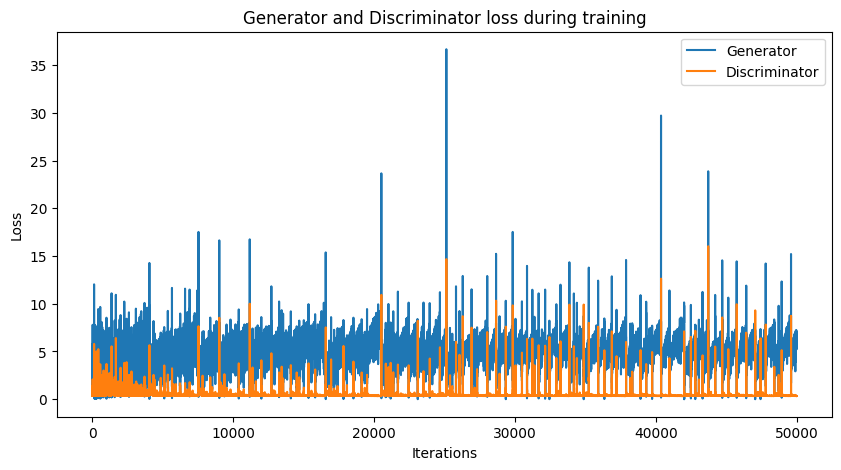

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator loss during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Lastly, [here's](https://drive.google.com/file/d/1-22Xy8S3eFYKJ71kH79jWVk8TC7pRL4s/view?usp=sharing) an animation visualizing the progression of the generator.


### Task 3: Training a **conditional DCGAN**

Let's define the generator and discriminator networks:

In [ ]:
# Create the generator
netG = Generator(z_size, image_size, num_channels, len(dataset.classes)).to(device)
netG.apply(init_weights)  # Initialize the weights

# Create the discriminator
netD = Discriminator(image_size, num_channels, len(dataset.classes)).to(device)
netD.apply(init_weights)

Discriminator(
  (convolutions): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Identity()
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (affine_1): Sequential(
    (0): Linear(in_features=2058, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (affine_2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
training_params = {
    'device': device,
    'train_iters': 22000,
    'lr': 2e-4,
    'show_every': 2200,
    'k': 1,
    'conditional': True,
    'label_smoothing': False
  }

train(netG, netD, training_params)

  0%|          | 0/22000 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

##### Step 3: Results

Firstly, let's plot the loss of the generator and discriminator networks during training:

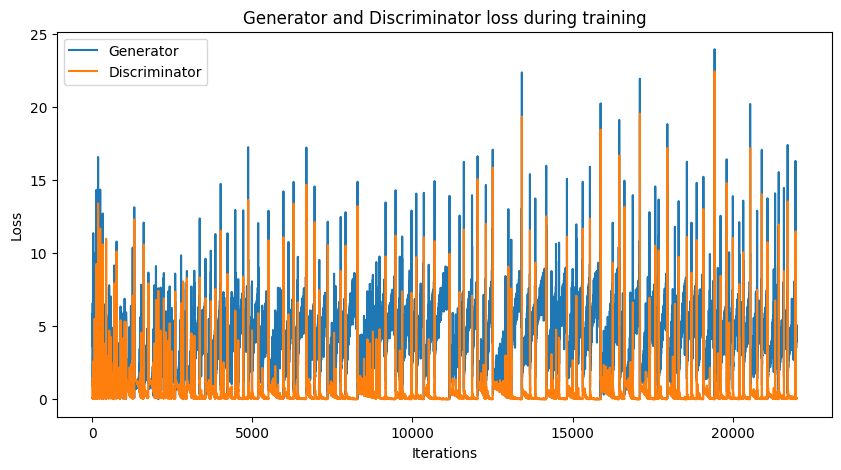

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator loss during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Lastly, [here's](https://drive.google.com/file/d/1jd2zVpXywFZXNNXAO2a0kOwy1p9ck36V/view?usp=sharing) an animation visualizing the progress of the generator.